In [ ]:
!pip install d2l==1.0.0-alpha0

# 14.8 Region-based CNNs (R-CNNs)

single shot multibox detection과 더불어서 R-CNNs(region-based CNN, regions with CNN features)는 object detection 분야에 딥러닝을 적용하는데 있어 선구적인 접근 방식 중 하나이다. 이번 섹션에서 R-CNN과 발전된 형태인 fast R-CNN, faster R-CNN, mask R-CNN을 소개하도록 한다. <br>
(책에서는 공간의 부족으로 각 모델들의 디자인적인 측면만을 다룬다.)



## R-CNNs

R-CNN은 input image로부터 많은 region proposal을 추출하여 class와 bounding boxes(오프셋)을 라벨링한다. (일전에 살펴본 anchor box 역시 region proposal로 간주할 수 있음)



![The R-CNN model.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/r-cnn.svg?raw=1)

그림은 R-CNN에 대한 설명이다. 조금 더 명확하게 R-CNN은 다음의 네 단계로 이루어진다.

1. 선택적 탐색(selected search)를 수행하여 입역 이미지에서 여러 고품질 region proposal을 추출한다. 이런 region proposal들은 다양한 모양과 크기로 선택된다. 각각의 region proposal들은 class와 더불어서 ground-truth bounding box로 라벨링된다.
2. pretrained CNN을 선택하여 출력 계층 직전에 잘라낸다. 각 region proposal의 크기를 네트워크에 필요한 입력 크기로 조정하고, forward propagation를 통해 각 region proposal의 특징들을 출력(feature extraction)한다.
3. 추출된 특징들과 각 region proposal의 라벨링된 클래스들을 가지고 support vector machine을 훈련한다. 여기서의 각 support vector machine은 각 region proposal들에 특정 클래스가 추출된 특징에 포함되어 있는지 체크한다.
4. 3번에서처럼 추출된 특징들과 라벨링된 bounding box를 가지고 선형 회귀를 학습시켜 ground-truth bounding box를 예측하도록 한다.

비록 R-CNN이 이미지의 특징들을 효율적으로 뽑아내도록 사전학습된 CNN을 사용하지만 매우 느리다. 각 input image로부터 수 천개씩 region proposal을 선택해 해당 과정을 수행한다면, 수 천번의 forward propagation 연산을 해야한다. 이런 거대한 계산 부하는 R-CNN이 현실 세계에서 널리 쓰이지 못하게 막는 요인이다.

## Fast R-CNN

R-CNN의 병목 현상은 각 region proposal이 독립적으로 CNN forward propagation을 수행하고 계산적인 부분에 공유가 없다는데에 있다. 이러한 region들은 상당히 overlap되기 때문에, 독립적인 feature extraction은 반복 계산을 하게 만든다. R-CNN에 비해 fast R-CNN의 개선점 중 하나는 CNN의 forward 연산이 전체 이미지에 대해서만 수행된다는 것이다.

![The fast R-CNN model.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/fast-rcnn.svg?raw=1)

해당 그림은 fast R-CNN model을 묘사하고 있는데, 주요 계산은 다음과 같다.

1. R-CNN과 비교해 fast R-CNN은 각각의 region proposal보다는 전체 이미지에 대해 feature extraction을 수행한다.이러한 CNN은 훈련이 가능하다. input image가 주어지면 CNN의 output 모양은 $1 \times c \times h_1  \times w_1$이 된다.
2. selective search가 n개의 region proposal을 만들어낸다 가정해보자. 이러한 region proposal은 CNN의 출력물에 (다른 모양의) 관심 영역(regions of interest)을 표시한다. 이런 관심 영역(region of intersest)을 쉽게 연결하기 위해 쉽게 연결하기 위해 동일한 모양의 feature (height h2와 width w2는 특정됨)를 추가로 추출한다. 이를 달성하기 위해 fast R-CNN은 RoI(region of interest) pooling layer를 도입한다.CNN 출력과 region proposal이 이 계층에 입력되어 모든 region proposal에서 추출된 feature들이 $n \times c \times h_2 \times w_2 $모양의 features가 되도록 연결(concatenate)한다.
3. fully connected layer를 이용해 concatenated features가 $n \times d$ 모양이 되도록 한다. ($d$는 모델 디자인시 설정)
4. 각 n개의 region proposal에 대해 class와 bounding box를 예측한다. 구체적으로 fully connected layer를 사용해 $n \times q$($q$는 class의 수) 모양의 output과 $n \times 4$ 모양의 output으로 각각 변환한다. 클래스 예측에서는 softmax regression을 사용한다.

fast R-CNN에서 제안된 RoI pooling layer는 일반적인 pooling layer와는 다른점을 가지고 있다. 일반적인 pooling layer는 pooling window, padding, stride의 크기를 지정하여 출력 모양을 간접적으로 제어하지만 RoI pooling layer에서는 출력 모양을 직접 지정할 수 있다.

예를 들어 각 영역의 출력 높이와 폭을 각각 $h_2$와 $w_2$로 지정했다 하자. $h \times w$모양의 region of interest(관심영역) window에 대해서도, 이런 window는 $h_2$ and $w_2$의 subwindow의 격자로 분할되며, 각 subwindow는 $(h/h_2) \times (w/w_2)$와 비슷한 크기를 갖게 된다. 실제로 subwindow의 width와 height를 반올림하고 subwindow의 출력으로 가장 큰 요소를 사용해야한다. 따라서 region of interest의 모양이 다른 경우에도 RoI pooling layer는 동일한 모양의 feature를 추출해낼 수 있다.

다음 그림에 나와있듯이 $4 \times 4$ input image에서 좌상단의 $3\times 3$ region of intersest가 선택되었다하자. 이런 region of interest에 대해 $2\times 2$ output을 얻기 위해 $2\times 2$ region of interest pooling layer를 사용한다. <br>
예시) 0,1,4,5 -> 5 / 2,6 -> 6 / 8,9 -> 9 / 10 -> 10

![A $2\times 2$ region of interest pooling layer.](http://d2l.ai/_images/roi.svg)

RoI pooling layer의 연산을 직접 계산해보자. CNN으로 추출된 feature는 $4 \times 4$라 하고 single channel이라 가정한다.

In [ ]:
import torch
import torchvision

X = torch.arange(16.).reshape(1, 1, 4, 4)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

또한 input image의 height와 width가 모두 40 pixel이고 selective search를 통해 2개의 region proposal을 생성했다 하자. 각 region proposal들은 object class, 좌상단 x,y좌표, 우하단 x,y좌표, 총 다섯개의 원소로 표현된다.


In [ ]:
rois = torch.Tensor([[0, 0, 0, 20, 20], [0, 0, 10, 30, 30]])

extracted feature(X)의 크기가 input image에 비해 1/10밖에 안되기 때문에, 두 region proposal의 좌표에 0.1을 곱한다.<br>
(torchvision에서 제공되는 함수의 spatial_scale 인자)<br>
두개의 region of interests는 X에 X[:, :, 0\~2, 0\~2] and X[:, :, 1\~3, 0\~3]로 표시된다.<br>
마지막으로 $2\times 2$ region of interest pooling에서 region of interest를 subwindow 그리드로 분할하여 동일한 $2 \times 2$ 모양의 특징을 추가로 추출한다.


In [ ]:
torchvision.ops.roi_pool(X, rois, output_size=(2, 2), spatial_scale=0.1)

tensor([[[[ 5.,  6.],
          [ 9., 10.]]],


        [[[ 9., 11.],
          [13., 15.]]]])

## Faster R-CNN
객체 검출을 보다 정확하기 하기 위해 fast R-CNN은 selective search에서 많은 region proposal를 생성해내야 한다. 정확도 감소 없이 region proposal을 줄이기 위해 faster R-CNN 구조는 selective search를 region proposal network로 대체할 것을 제안한다.


![The faster R-CNN model.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/faster-rcnn.svg?raw=1)


위 그림은 faster R-CNN의 구조를 보여준다. fast R-CNN에 비해 faster R-CNN은 selective search 방식만 region proposal network로 바꾼 것이다. 모델의 나머지 부분은 바뀌지 않았다. region proposal network는 다음 과정을 따른다.


1. CNN output(features)을 padding이 1인 $3\times 3$ convolutional layer를 사용해  $c$ channel의 새 output으로 변환한다. 이와 같이 CNN에서 추출된 feature map의 공간 차원에 따른 각 유닛은 $c$의 새로운 특징 벡터를 얻는다.
2. feature map의 각 픽셀을 중심으로 다른 scale과 aspect ratio가 다른 여러 anchor를 생성하고 라벨을 붙인다.
3. feature map의 중앙에 있는 길이 c의 벡터를 이용해 이 anchor box가 background인지 object인지 구분하는 이진 예측과 bounding box 예측을 수행한다.

4. 예측 클래스가 object인 bounding boxes를 고려한다.non-maximum suppression을 이용해 overlap된 결과를 지운다. 해당 object로 예측되는 남아있는 bounding box들은 RoI pooling layer에 요구되는 region proposal이다.

faster R-CNN 모델의 일부로서 region proposal network는 모델의 나머지 부분과 공동으로 훈련된다. 즉, fater R-CNN의 목적함수는 object detection하여 class와 bounding box 예측하는 부분 뿐 아니라 region proposal network에서의 class 이진분류와 bounding box prediction을 포함한다. end-to-end 학습의 결과로 region proposal network는 높은 퀄리티의 region proposal를 만들어내는 것을 익힌다. 그러한 결과로 데이터에서 학습되는 region proposal의 수를 줄이면서도 object detection의 정확성을 유지한다.  



## Mask R-CNN

training dataset에서 검출하고자 하는 object의 pixel 수준의 위치가 image에 라벨링 되어있다면 mask R-CNN은 그러한 디테일한 정보를 활용해 object detection의 정확도를 향상시킬 수 있다.

![The mask R-CNN model.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/mask-rcnn.svg?raw=1)

그림에서 보듯이 mask R-CNN은 faster R-CNN에 기반해 수정되었다. 특히 RoI pooling layer를 RoI alignment layer로 대체하였다.이 RoI alignment layer는 bilinear interpolation을 사용하여 feature map의 공간 정보를 보존하며, 이는 pixel 수준의 예측에 더욱 적합하다. 이 layer의 출력에는 모든 regions of interest에 대해 동일한 feature map이 포함된다.  이러한 것들은 각 region of interest에 대해 class와 bounding box 예측 뿐 아니라 추가적인 fully convolution network를 통해 객체의 pixel 수준의 위치를 예측하는데에도 사용된다. (픽셀 레벨에서의 의미를 예측하는 방법은 segmantic segmantation에서 다룸)



## Summary


* R-CNN은 입력 이미지에서 많은 region proposal을 추출하고, CNN을 사용하여 각 region proposal에 대해 forward propagation를 수행하여 특징을 추출한 다음, 이러한 특징을 사용하여 이 region proposal의 class와 bounding box를 예측한다.
* fast R-CNN에서 개선된 주요 기능 중 하나는 CNN forward propagation을 전체 이미지에 대해서만 수행한다는 것이다. 또한 RoI pooling layer를 도입하여 모양이 다른 region of interest에 대해 동일한 모양의 feature를 추가로 추출하도록 한다.
* fater R-CNN은 fast R-CNN에서 사용된 selective search를 region proposal network로 같이 훈련시켜 region proposal의 수를 줄이면서 object detection의 정확도를 유지할 수 있다.
* faster R-CNN에 근거해 mask R-CNN은 픽셀 수준의 라벨을 활용해 object detection의 정밀도를 한층 더 향상시키기 위해, fully convolution network를 추가로 도입한다.

# 14.9 Semantic Segmentation and the Dataset

object detection task에서 직사각형의 bounding box는 이미지 내의 객체를 라벨링하고 예측하는데에 사용된다. 이 섹션에서는 이미지를 다른 semantic 클래스에 속하는 영역으로 분할하는 방법에 초점을 맞춘 semantic segmentation 문제에 대해 설명한다. object detection과 달리 semantic segmentation은 이미지 안에 있는 것들을 픽셀 단위로 인식하고 이해한다. 


![Labels of the dog, cat, and background of the image in semantic segmentation.](http://d2l.ai/_images/segmentation.svg)


## Image Segmentation and Instance Segmentation

computer vision 분야에서는 semantic segmentation과 유사한, 이미지 분할(image segmentation)과 인스턴스 분할(instance segmentation), 두 가지 중요한 작업 있다.

- Image segmentation은 이미지를 여러 구성 영역으로 분할한다. 이런 유형의 문제에 대한 방법으로 픽셀 간 상관관계를 사용한다. 훈련 중에는 이미지 픽셀에 대한 라벨 정보가 필요하지 않으며, segmented된 영역에 대해 예측으로 얻기를 원하는 semantics(의미)를 갖는다는 보장은 없다. 위 개와 고양이 이미지에서 image segmentation은 개를 두 영역으로 나눌 수도 있다.<br>
(ex) 검은색이 많은 얼굴 부분과 갈색이 많은 몸통 부분)
- Instance segmentation은 동시 검출 및 분할(simultaneous detection and segmentation)이라고도 한다. 이미지에서 픽셀 수준 영역을 인식하는 방법을 연구한다. semantic segmentation과 달리 instance segmantation은 semantics 뿐 아니라 다른 object instance도 구분해야한다. 예를 들어 이미지에 두 개의 개가 있는 경우 instance segmentation에서는 픽셀이 두 개 중 어느 개에 속하는지를 구별해야한다.





## The Pascal VOC2012 Semantic Segmentation Dataset

semantic segmentation의 가장 중요한 데이터 셋은
[Pascal VOC2012](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/) 이다. 우선은 이 데이터셋에 대해 살펴보도록 한다.



In [ ]:
%matplotlib inline
import os
import torch
import torchvision
from d2l import torch as d2l

In [ ]:
d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
                           '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')
# ../data/VOCdevkit/VOC2012 위치에 추출
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')

데이터셋 경로 입력 후 데이터셋의 다양한 컴포넌트를 볼 수 있다. 'ImageSets/Segmentation' 경로에는 train 및 test 샘플을 지정하는 텍스트 파일이 포함되어있다. 반면에 JPEGImages와 SegmentationClass 경로는 각 example에 대한 input image와 라벨이 저장된다. 라벨 역시 input image와 같은 크기의 이미지 형식이다. 또 어느 라벨 이미지에서도 같은 색을 가지는 픽셀은 같은 semantic(의미) 클래스에 속한다.



In [ ]:
# 해당 함수는 모든 input image와 label을 읽어들이는 기능을 한다.
def read_voc_images(voc_dir, is_train=True):
    """Read all VOC feature and label images."""
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    mode = torchvision.io.image.ImageReadMode.RGB
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    for i, fname in enumerate(images):
        features.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'JPEGImages', f'{fname}.jpg')))
        labels.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'SegmentationClass' ,f'{fname}.png'), mode))
    return features, labels

train_features, train_labels = read_voc_images(voc_dir, True)

In [ ]:
len(train_features)

1464

(-0.5, 499.5, 374.5, -0.5)

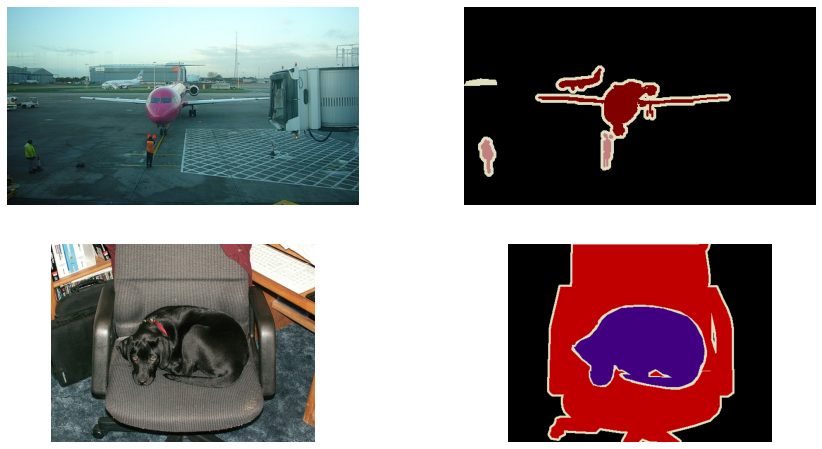

In [ ]:
# 이미지 예시
import matplotlib.pyplot as plt
import numpy as np
fig,axes = plt.subplots(2,2,figsize=(15,8))

axes[0,0].imshow(np.transpose(train_features[0],(1,2,0)))
axes[0,0].axis('off')
axes[0,1].imshow(np.transpose(train_labels[0],(1,2,0)))
axes[0,1].axis('off')
axes[1,0].imshow(np.transpose(train_features[2],(1,2,0)))
axes[1,0].axis('off')
axes[1,1].imshow(np.transpose(train_labels[2],(1,2,0)))
axes[1,1].axis('off')

이 데이터 세트의 모든 라벨에 대한 RGB 색상 값과 클래스 이름을 열거한다.


In [ ]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

위에 정의된 두 상수로 각 픽셀에 대한 클래스 인덱스를 편리하게 찾을 수 있다.


In [ ]:
# RGB 값에서 class index를 매핑하는 함수
def voc_colormap2label():
    """Build the mapping from RGB to class indices for VOC labels."""
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[
            (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    return colormap2label

# Pascal VOC2012 데이터 세트의 클래스 인덱스에 RGB 값을 매칭하는 함수
def voc_label_indices(colormap, colormap2label):
    """Map any RGB values in VOC labels to their class indices."""
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

예를 들어 첫 번째 예시 이미지에서, 비행기의 앞부분의 클래스 인덱스는 1이고, 배경 인덱스는 0이다.


In [ ]:
y = voc_label_indices(train_labels[0], voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]), 'aeroplane')

tensor([ 0,  1, 15])


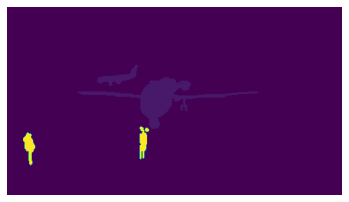

In [ ]:
plt.imshow(y)
plt.axis('off')
print(y.unique())

### Data Preprocessing

모델에 필요한 입력 모양에 맞게 이미지의 크기가 조정되는 것이 보통이지만 semantic segmantation에서는 예측된 픽셀 클래스를 입력 이미지의 원래 모양으로 다시 scaling해야한다. 이러한 rescaling은 특히 다른 클래스의 segment에 대해 부정확할 수 있다. 이런 문제를 피하기 위해 rescaling하는 대신 고정된 모양으로 잘라낸다. (random cropping)


In [ ]:
def voc_rand_crop(feature, label, height, width):
    """Randomly crop both feature and label images."""
    rect = torchvision.transforms.RandomCrop.get_params(
        feature, (height, width))
    feature = torchvision.transforms.functional.crop(feature, *rect)
    label = torchvision.transforms.functional.crop(label, *rect)
    return feature, label

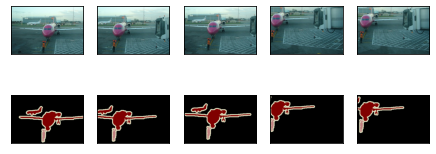

In [ ]:
n=5
imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)

imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

### [**Custom Semantic Segmentation Dataset Class**]

pytorch에서 high-level API로 제공되는 Dataset class를 상속함으로써 custom semantic segmentation dataset class인 VOCSegDataset을 정의한다. __getitem__ 메서드를 수정함으로써 idx로서 데이터셋에서 인덱스화된 input image와 각 픽셀의 클래스 인덱스에 임의로 접근할 수 있다. 데이터셋의 일부 이미지는 random cropping 출력보다 작기 때문에 이런 이미지는 filter 함수라는 custom 기능에 의해 제외된다. 추가로 normalize_image 함수를 두어 각 input image의 각 채널별 standardize를 수행한다.


In [ ]:
class VOCSegDataset(torch.utils.data.Dataset):
    """A customized dataset to load the VOC dataset."""

    def __init__(self, is_train, crop_size, voc_dir):
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        return self.transform(img.float() / 255)

    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[1] >= self.crop_size[0] and
            img.shape[2] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature, voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

### [**Reading the Dataset**]

'VOCSegDataset' class를 이용해 training set와 test set의 인스턴스를 각각 만든다. random cropping된 이미지는 $320\times 480$으로 한다.


In [ ]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples
read 1078 examples


배치 사이즈를 64로 하여 training set에 대한 data iterator (data loader)를 정의한다. 


In [ ]:
batch_size = 64
train_iter = torch.utils.data.DataLoader(voc_train, batch_size, shuffle=True,
                                    drop_last=True,
                                    num_workers=d2l.get_dataloader_workers())
# 미니배치 크기 하나 출력
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([64, 3, 320, 480])
torch.Size([64, 320, 480])


### [**Putting All Things Together**]

마지막으로 Pascal VOC2012 semantic segmentation dataset을 data loader형태로 다운로드 하는 함수를 정의한다. 이 함수는 training과 test dataset를 반환한다.



In [ ]:
def load_data_voc(batch_size, crop_size):
    """Load the VOC semantic segmentation dataset."""
    voc_dir = d2l.download_extract('voc2012', os.path.join(
        'VOCdevkit', 'VOC2012'))
    num_workers = d2l.get_dataloader_workers()
    train_iter = torch.utils.data.DataLoader(
        VOCSegDataset(True, crop_size, voc_dir), batch_size,
        shuffle=True, drop_last=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir), batch_size,
        drop_last=True, num_workers=num_workers)
    return train_iter, test_iter

## Summary

* Semantic segmentation은 다른 semantic 클래스에 속하는 영역으로 분할함으로써 이미지를 픽셀 수준에서 인식하는 것이다.
* semantic segmentation dataset 중 가장 중요한 데이터셋 중 하나는 Pascal VOC2012이다.
* semantic segmentation에서 input image와 라벨은 픽셀 단위로 1:1 대응하기 때문에 input image에 대한 rescale보다는 random crop을 사용한다.


# 14.10 Transposed Convolution

지금껏 살펴본 CNN은 일반적으로 input의 공간적 차원을 감소시키거나 유지시킨다.(convolutional layer, pooling layer 등)<br>
픽셀 수준에서 분류를 수행하는 semantic segmentation에서는 input과 output의 차원수가 같으면 편리하다. 예를 들어 ouput의 픽셀의 channel dimension은 input 픽셀의 분류 결과를 같은 공간적 위치에 유지시킬 수 있다.

이러한 것들을 하기 위해 CNN layer에 의해 dimension이 줄어든 후, 다른 타입의 CNN layer를 사용해 중간의 featrue map등의 dimension을 증가시킬 수 있다. 이번 섹션에서는 fractionally-strided convolution이라고도 하는 "transposed convolution"을 이용해 다운샘플링(downsampling) 연산을 역방향으로 하는 것을 살펴볼 것이다.



In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

## Basic Operation

일단 channel은 무시한채 stride=1이고 padding이 없는 기본적인 transposed convolution operation을 살펴보도록 한다. $n_h \times n_w$의 크기를 갖는 input tensor와 $k_h \times k_w$의 크기를 갖는 kernel이 있다고 가정하자. kernel window는 각각 행과 열 방향으로 $n_h$번, $n_w$번 이동하는데 총 $n_h n_w$개의 중간 결과를 만들어내게 된다. 각각의 중간 결과는 $(n_h + k_h - 1) \times (n_w + k_w - 1)$ 크기의 0으로 초기화된 tensor이다. 각 중간 결과를 계산하기 위해서는 input tensor의 각 element가 kernel과 곱해지고, 그러한 결과로 $k_h \times k_w$  tensor를 만들어내는데 각 중간 결과의 부분을 대체하게 된다. 각 중간 텐서(결과)에서 교체된 부분의 위치는 계산에 사용된 input tensor의 요소 위치에 해당한다. 최종적으로 모든 모든 중간 결과를 집계하여 출력을 생성한다.

다음 그림은 어떻게 $2\times 2$ kernel을 가진 transposed convolution가  $2\times 2$ input tensor를 계산하는지 나타낸다.


![Transposed convolution with a $2\times 2$ kernel. The shaded portions are a portion of an intermediate tensor as well as the input and kernel tensor elements used for the  computation.](http://d2l.ai/_images/trans_conv.svg)



In [ ]:
# input matrix X와 kernel matrix K에 대해 transoposed convolution operation을 구현할 수 있다.
def trans_conv(X, K):
    h, w = K.shape
    Y = torch.zeros((X.shape[0] + h - 1, X.shape[1] + w - 1))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Y[i: i + h, j: j + w] += X[i, j] * K
    return Y

kernel을 통해 입력 요소를 줄이는 일반 convolution과는 달리 transposed convolution은 kernel을 통해 입력 요소를 broadcast하므로 입력보다 더 큰 출력을 생성한다. input tensor X와 kernel tensor K를 구성하여 해당 연산의 output을 검증해볼 수 있다.


In [ ]:
X = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
trans_conv(X, K)

tensor([[ 0.,  0.,  1.],
        [ 0.,  4.,  6.],
        [ 4., 12.,  9.]])

또는 input X와 kernel K가 둘다 4차원 tensor일 때, pytorch에서 제공되는 high-level API를 사용하여 동일한 결과를 얻을 수 있다.



In [ ]:
X, K = X.reshape(1, 1, 2, 2), K.reshape(1, 1, 2, 2)
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, bias=False)
tconv.weight.data = K
tconv(X)

tensor([[[[ 0.,  0.,  1.],
          [ 0.,  4.,  6.],
          [ 4., 12.,  9.]]]], grad_fn=<ConvolutionBackward0>)

## [**Padding, Strides, and Multiple Channels**]

입력에 padding이 적용되는 일반 convolution과 달리 transposed convolution은 output에 padding을 적용한다. 예를 들어 높이과 너비의 양쪽 padding 번호를 1로 지정하면 첫 번째 및 마지막 행과 열이 transposed된 convolution 출력에서 제거된다.


In [ ]:
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, padding=1, bias=False)
tconv.weight.data = K
tconv(X)

tensor([[[[4.]]]], grad_fn=<ConvolutionBackward0>)

transposed convolution에서 stride는 입력이 아닌 중간결과(출력)에 대해 지정된 것이다. 위에서 본 그림과 마찬가지로 $2\times 2$ kernel을 가진 transposed convolution가  $2\times 2$ input tensor에 대해 stride 2일 때 어떻게 동작하는지 나타낸 것인데 중간결과의 높이와 무게가 모두 증가한다.



![Transposed convolution with a $2\times 2$ kernel with stride of 2. The shaded portions are a portion of an intermediate tensor as well as the input and kernel tensor elements used for the  computation.](http://d2l.ai/_images/trans_conv_stride2.svg)

다음 코드는 이러한 연산의 결과를 나타낸다.


In [ ]:
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, stride=2, bias=False)
tconv.weight.data = K
tconv(X)

tensor([[[[0., 0., 0., 1.],
          [0., 0., 2., 3.],
          [0., 2., 0., 3.],
          [4., 6., 6., 9.]]]], grad_fn=<ConvolutionBackward0>)

여러 channel을 갖는 input과 output에 대해 transposed convolution은 일반 convolution과 동일한 방식으로 동작한다. 입력이 $c_i$개의 channel이 있다고 가정하면 transposed convolution은 $k_h\times k_w$ 모양의 kernel을 각각의 input channel에 적용한다. 만일 output channel이 여러 개로 지정되면, $c_i\times k_h\times k_w$의 kernel이 각 output channel마다 생성된다.

마찬가지로, 우리가 $X$를 convolutional layer $f$를 넣어 output $Y=f(X)$을 얻고 $f$와 output channel의 수를 제외한 모든 parameter가 같은 transposed convolutional layer $g$를 생성한다면, $g(Y)$는 X와 같은 shape를 같게 된다.


In [ ]:
X = torch.rand(size=(1, 10, 16, 16))
# input과 output의 channel만 반대이고 나머지 hyperparameters는 모두 동일한 convolution layer, transoposed convolution layer
conv = nn.Conv2d(10, 20, kernel_size=5, padding=2, stride=3)
tconv = nn.ConvTranspose2d(20, 10, kernel_size=5, padding=2, stride=3)
print('X의 shape : ',X.shape)
print('g(f(X))의 shape : ',tconv(conv(X)).shape)

X의 shape :  torch.Size([1, 10, 16, 16])
g(f(X))의 shape :  torch.Size([1, 10, 16, 16])


## [**Connection to Matrix Transposition**]

transposed convolution는 행렬 전치에서 따와 명명되었다. 이를 설명하기 위해 우선 행렬 곱셈을 사용하여 convolution을 구현하는 방법을 살펴보도록 한다.
$3\times 3$ input X와 $2\times 2$ kernel K를 정의한다. 그리고 corr2d 함수를 사용하여 convolution output Y를 계산한다.

In [ ]:
from IPython.display import display

In [ ]:
X = torch.arange(9.0).reshape(3, 3)
display(X)
K = torch.tensor([[1.0, 2.0], [3.0, 4.0]])
display(K)
Y = d2l.corr2d(X, K)
display(Y)

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])

tensor([[1., 2.],
        [3., 4.]])

tensor([[27., 37.],
        [57., 67.]])

다음으로 convolution kernel K를 0이 대량 포함된 희소한 weight matrix(가중치 행렬) W로써 다시 쓴다. weight matrix의 shape은 (4,9)이인데 convolution kernel K에서 0이 아닌 원소들이 나온 것이다.

In [ ]:
def kernel2matrix(K):
    k, W = torch.zeros(5), torch.zeros((4, 9))
    k[:2], k[3:5] = K[0, :], K[1, :]
    W[0, :5], W[1, 1:6], W[2, 3:8], W[3, 4:] = k, k, k, k
    return W

display(K)
W = kernel2matrix(K)
display(W)

tensor([[1., 2.],
        [3., 4.]])

tensor([[1., 2., 0., 3., 4., 0., 0., 0., 0.],
        [0., 1., 2., 0., 3., 4., 0., 0., 0.],
        [0., 0., 0., 1., 2., 0., 3., 4., 0.],
        [0., 0., 0., 0., 1., 2., 0., 3., 4.]])

X를 row by row로 연결해 길이 9짜리 벡터를 얻는다. W와 벡터화된 X의 행렬 곱은 길이 4의 벡터를 나타낸다. reshape 후에 같은 모양의 출력 Y를 보통의 convolution operation으로부터 얻을 수 있다. 우리는 방금 행렬곱을 사용해 convolution을 구현하였다.



In [ ]:
display(X.reshape(-1))
Y == torch.matmul(W, X.reshape(-1)).reshape(2, 2)

tensor([0., 1., 2., 3., 4., 5., 6., 7., 8.])

tensor([[True, True],
        [True, True]])

마찬가지로 행렬 곱셈을 사용하여 transposed convolution을 구현할 수 있다. 다음 예에서 (위의 예에서 일반 convolution의 output인) $2\times 2$ Y를 transoposed convolution의 input으로써 취한다. 행렬들을 곱하여 이 연산을 구현하기 위해서는 weight matrix W만 (9,4)로 전치하면 된다.

In [ ]:
# Y는 일반 convolution layer의 output
Z = trans_conv(Y, K)
Z == torch.matmul(W.T, Y.reshape(-1)).reshape(3, 3)

tensor([[True, True, True],
        [True, True, True],
        [True, True, True]])

행렬을 곱하여 convolution을 구현하는 것을 고려해보자. convolution의 forwardpropagation 함수는 input vector $\mathbf{x}$와 weight matrix $\mathbf{W}$를 곱하여 $\mathbf{y}=\mathbf{W}\mathbf{x}$로 표현할 수 있다. backpropagation이 chain rule을 따르고 $\nabla_{\mathbf{x}}\mathbf{y}=\mathbf{W}^\top$이기 때문에 backpropagation 함수는 이 함수의 input과 전치된 weight matrix $\mathbf{W}^\top$를 곱함으로써 구현될 수 있다. 그러므로 transposed convolution layer는 단지 convolutional layer의 forwardpropagation과 backpropagation을 맞바꾼 것으로 볼 수 있다.(순전파와 역전파 시 input vector에 각각 $\mathbf{W}^\top$와 $\mathbf{W}$를 곱해준다.)


## Summary

* kernel을 통해 입력 요소를 줄이는 일반적인 convolution과는 달리 transposed colnvolution은 입력 요소를 kernel을 통해 broadcast하므로 입력보다 큰 출력이 생성된다.
* $\mathsf{X}$를  convolutional layer $f$에 넣은 output $\mathsf{Y}=f(\mathsf{X})$를 얻은 후 ($f$와 output channel number를 제외하고 동일한 hyperparameter를 지닌) transposed convolutional layer $g$를 만들어 $g(Y)$를 계산한다면 $\mathsf{X}$와 같은 shape를 갖는다.
* 행렬 곱셈을 사용하여 convolution을 구현할 수 있다. transposed convolution 층은 convolution 층의 순전파와 역전파 함수를 교환할 수 있다.

# 14.11 Fully Convolutional Networks

semantic segmentation은 이미지를 픽셀 수준으로 분류한다. fully convolutional network(FCN)는 이미지 픽셀을 픽셀 클래스로 변환하기 위해 convolutional neural network를 사용한다.

이미지 분류 또는 객체 감지를 위한 다른 일반적인 CNN들과 달리, FCN은 transposed convolutional layer를 통해 중간 feature map들의 높이와 폭을 input image의 높이와 폭으로 변환한다.

결과적으로, classification output과 입력 이미지는 픽셀 수준에서 일대일 대응된다. 임의의 output pixel에서 channel dimension은 input image의 pixel과 동일한 위치에서 classification 결과를 갖게 된다.

In [ ]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from d2l import torch as d2l

## The Model

FCN 모델의 디자인을 다음과 같다. 아래 그림과 같이 CNN을 사용하여 이미지 feaure를 추출한 다음, channel 수를 $1\times 1$ convolutionanl layer를 통해 class 수로 변환하고, 마지막으로 transposed convolution을 통해 입력 이미지와 동일한 width와 height가 되도록 모델의 output을 변환한다.

결과적으로, 모델 input과 output 이미지는 동일한 크기를 지니며, output channel은 동일한 공간 위치(spatial position)에서 입력 pixel에 대한 예측 클래스를 포함한다.

![Fully convolutional network.](http://d2l.ai/_images/fcn.svg)

ImageNet 데이터셋으로 사전 훈련된 ResNet-18 모델을 사용해 feature extract를 수행한다. 마지막 몇개의 layer들은 global pooling layer와 fully connected layer인데 이것들은 FCN에서 필요하지는 않으므로 제거하도록 한다.


In [ ]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
list(pretrained_net.children())[-3:]

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

In [ ]:
net = nn.Sequential(*list(pretrained_net.children())[:-2])

In [ ]:
# height 320, width 480인 input image에 대해 우리가 정의한 model의 forward propagation은 input의 1/32, 즉 10과 15로 감소시킨다.
X = torch.rand(size=(1, 3, 320, 480))
net(X).shape


torch.Size([1, 512, 10, 15])

다음으로, $1\times 1$ convolutional layer를 사용해 output의 channel 수를 데이터셋(Pascal VOC2012)의 class수인 21로 변환한다. 마지막으로, feature map의 width와 height를 32배 증가시켜 input 이미지와 같은 모양으로 다시 변경해야 합니다.



kernel height와 width를 64, padding을 16, stride를 32로 하여 transposed convolutional layer를 구성한다.

(참고 section7.3 convolution layer의 output shape을 계산하는 방법)<br>
$(320-64+16\times2+32)/32=10$ 와 $(480-64+16\times2+32)/32=15$ <br>
일반적으로 stride $s$의 경우, padding $s/2$ ($s/2$가 정수라고 가정)와 height와 width가 $2*s$인 kernel을 가진 transposed convolution은 input의 height와 width를 $s$배로 증가시킨다는 것을 알 수 있다.

In [ ]:
num_classes = 21
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))
net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes,
                                    kernel_size=64, padding=16, stride=32))

## **Initializing Transposed Convolutional Layers**

transposed convolutional layer가 feature map의 height와 width를 증가시킬 수 있다는 것을 이미 알고 있다. image processing에서는 upsampling과 같은 scale up할 필요가 있다. Bilinear interpolation(쌍선형 보간)은 upsampling 테크닉 중 하나이다. 이 기법은 transposed convolutional layer를 초기화하는데에 쓰이기도 한다.

bilinear 보간에 대해 얘기하기 위해 upsampling된 output 이미지의 각 pixel에 대해 계산하려고 하는 input image가 주어져있다 해보자. output image의 좌표 $(x,y)$의 pixel에 대해 계산하고자 할 때, 우선 $(x,y)$를 input image의 좌표 $(x', y')$에 mapping한다. (예를 들어 input size와 output size의 비율에 따라)

이때 $(x', y')$는 각각 실수이고 이 $(x', y')$와 가장 가까운 4개의 좌표를 input image에서 찾도록 한다. 

마지막으로 output의 pixel $(x,y)$는 input image의 $(x', y')$에서 가장 가까운 4개의 pixel과 상대적인 거리에 기반해 계산된다.

bilinear interpolation의 업샘플링은 다음의 bilinear_kernel 함수에 의해 구성된 kernel을 가진 transposed convolutional layer에 의해 구현된다.

In [ ]:
# 책에서는 해당 알고리즘의 상세한 설명은 생략함
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels,
                          kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

transposed convolutional layer에 의해 구현되는 **bilinear interpolation의 upsampling을 실험해보도록 한다. height와 weight를 배로 증가시키는 transposed convolutional layer를 설계하고 구현된 함수를 통해 kernel을 initialize하도록 한다.


In [ ]:
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2,
                                bias=False)
# ;는 출력 생략
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4));

input image X를 읽어들이고 upsampling된 output을 Y에 할당한다.


In [ ]:
img = torchvision.transforms.ToTensor()(Image.open('catdog.jpg'))
# 이미지 출력을 위한 channel dimension의 위치 조정
X = img.unsqueeze(0)
Y = conv_trans(X)
out_img = Y[0].permute(1, 2, 0).detach()

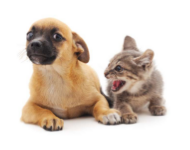

In [ ]:
plt.imshow(np.transpose(X[0],(1,2,0)))
plt.axis('off')
plt.show()

transposed convolutional layer는 이미지의 size를 모두 2배 증가시킨다. 좌표의 다른 scale을 제외하고, bilinear interpolation으로 확대된 이미지와 원본 이미지는 동일하게 보임

input image shape: torch.Size([561, 728, 3])
output image shape: torch.Size([1122, 1456, 3])


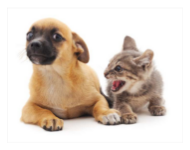

In [ ]:
print('input image shape:', img.permute(1, 2, 0).shape)
plt.imshow(img.permute(1, 2, 0));
plt.axis('off')
print('output image shape:', out_img.shape)
plt.imshow(out_img);
plt.axis('off')
plt.show()

FCN에서,  transposed convolutional layer는 bilinear보간의 upsampling으로 초기화하고 $1\times 1$ convolution layer의 경우 Xavier초기화를 사용한다.

In [ ]:
W = bilinear_kernel(num_classes, num_classes, 64)
net.transpose_conv.weight.data.copy_(W);

## **Reading the Dataset**

 semantic segmentation 데이터 세트를 이미 읽어왔다. output shape은 random cropping으로 320x480으로 지정됩니다. <br>(height와 width는 모두 32로 나누어 떨어지는 수)


In [ ]:
batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)

read 1114 examples


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


read 1078 examples


## **Training**

데이터셋과 모델 구성에 대한 준비가 끝났으니 train을 진행할 수 있다. loss function과 정확도 계산은 지금까지와 크게 다르지 않지만 약간의 설정이 조금 더 필요하다. transposed convolutional layer의 output(출력) channel을 이미지의 각 pixel class 예측에 사용하기 때문에, channel dimension은 loss 계산에 지정(specified)된다. 또 정확도 같은 경우 모든 pixel에 대해 예측된 class가 올바른지 계산해 산출한다.

loss 0.409, train acc 0.873, test acc 0.855
77.6 examples/sec on [device(type='cuda', index=0)]


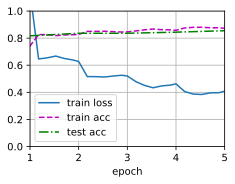

In [ ]:
def loss(inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

num_epochs, lr, wd, devices = 5, 0.001, 1e-3, d2l.try_all_gpus()
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
# multiple GPU로 학습되도록 짜여진 함수
# net = nn.DataParallel(net, device_ids=devices).to(devices[0])
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

## **Prediction**

예측시에는 각 channel마다 input image를 표준화한 후, 정의된 CNN 모델에서 요구하는 input 형태인 4차원 형식으로 변환해야한다.

In [ ]:
def predict(img):
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    pred = net(X.to(devices[0])).argmax(dim=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

각 pixel의 예측 클래스를 시각화하기 위해 예측 클래스를 데이터 세트의 레이블 색상에 다시 매핑한다.

In [ ]:
def label2image(pred):
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])
    X = pred.long()
    return colormap[X, :]

test set의 이미지는 size가 고정되어있지 않다. 정의한 모델은 stride = 32의 transposed convolutional layer를 사용하기 때문에, test set의 이미지 width와 height가 32로 나눠떨어지지 않는 경우 output이 input image와 다른 size일 수 있다. 이러한 문제를 대처하기 위해 width와 height가 32의 정수배인 직사각형 영역을 여러 개 잘라내고 이러한 각 영역의 pixel에 대해 개별적으로 forward propagation을 수행할 수 있다. 개별적 수행 후 이러한 직사각형 영역의 union은 input image를 완전히 덮어야한다. 같은 pixel이 여러 직사각형 영역으로 덮여있는 경우, softmax 함수에 입력해 클래스를 예측할 수 있다.

간단하게, 몇 개의 더 큰 test image를 읽고 좌상단 모서리에서 시작하여 예측을 위해 $320\times480$ 영역을 잘라낸다. 

실행결과는 줄별로 잘라낸 영역, 예측 결과, ground-truth 영역이 시각화된다.

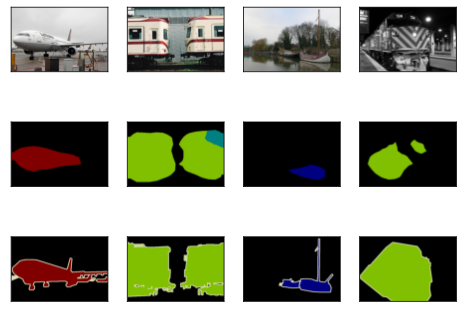

In [ ]:
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [X.permute(1,2,0), pred.cpu(),
             torchvision.transforms.functional.crop(
                 test_labels[i], *crop_rect).permute(1,2,0)]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);

## Summary

* FCN은 먼저 CNN을 사용하여 image feature를 추출한 다음 $1\times 1$ convolutional layer를 통해 channel수를 분류하고자 하는 class의 수로 변환하고, eature map의 height와 width를 transposed convolution을 통해 input image의 크기와 맞게 변환한다.

* FCN에서는 bilinear 보간의 upsampling을 이용해 transposed convolutional layer를 초기화할 수 있다.

